#  RIF Data Wrangling - GDELT

In this notebook, We will go through how to use Google BigQuery to access the GDELT project data, and some simple usage cases.  

Useful References:  
- Google Cloud
    - Google BigQuery: https://cloud.google.com/bigquery
    - Authenticate with Google Cloud: https://hevodata.com/learn/bigquery-jupyter-notebook/#w5
    - Google BigQuery Python Documantation: https://cloud.google.com/python/docs/reference/bigquery/latest/index.html
    - Google BigQuery Python Samples:https://cloud.google.com/bigquery/docs/samples
- GDELT
    - Raw Data: http://data.gdeltproject.org/events/index.html
    - A description of the data fields: http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf
    - The event codes are described in this document: http://gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf
    - CAMEO country codes are listed here: https://www.gdeltproject.org/data/lookups/CAMEO.country.txt
    - FIPS country codes are listed here: https://www.gdeltproject.org/data/lookups/FIPS.country.txt

In [ ]:
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
!pip install db-dtypes

In [40]:
import os
import matplotlib.pyplot as plt
from google.cloud import bigquery
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import numpy as np

In [3]:
%load_ext google.cloud.bigquery

## **Step 0**: Google BigQuery Account

Authenticate with Google Cloud:  
You need to authenticate your Python code to access Google Cloud resources. You can do this by creating a service account and downloading the JSON key file.  
- Create a service account and download the JSON key file (reference: https://hevodata.com/learn/bigquery-jupyter-notebook/#w5):
    - Go to the Google Cloud Console.
    - Navigate to "IAM & Admin" > "Service accounts."
    - Click "Create Service Account," fill out the details, and grant the necessary permissions (BigQuery User or Editor role).
    - Create and download a JSON key file for the service account.
- Set the GOOGLE_APPLICATION_CREDENTIALS environment variable to point to your JSON key file:  
```python
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "path-to-CREDENTIALS.json"
```

In [6]:
# Setting your Google application credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "bigquery-key.json"

- Simple test (good to continue if you see a table output)

In [7]:
# Construct a BigQuery client object.
client = bigquery.Client()
sql = """
SELECT
    plurality,
    COUNT(1) AS count,
    year
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(plurality) AND plurality > 1
GROUP BY
    plurality, year
ORDER BY
    count DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,plurality,count,year
0,2,139209,2007
1,2,138866,2008
2,2,137239,2006
3,2,133285,2005
4,2,132344,2004


## BigQuery GDELT Dataset Overview

The database structure is project --> dataset --> table. The project id for the GDELT project in Google BigQuery is `"gdelt-bq"`.   

### 1. Datasets and tables.  
First, we investigate what datasets and tables are accessible.

In [8]:
# Project id of the GDELT project
project_id = "gdelt-bq"

# Create a BigQuery client object
client = bigquery.Client(project=project_id)

In [9]:
# List all datasets and tables in the GDELT project
datasets = list(client.list_datasets())

# Iterate through each dataset and list its tables
for dataset in datasets:
    print("Dataset: {}".format(dataset.dataset_id))
    tables = list(client.list_tables(dataset))
    table_names = [table.table_id for table in tables]
    print("Tables: {}\n--------".format(", ".join(table_names)))

Dataset: covid19
Tables: onlinenews, onlinenewsgeo, tvnews
--------
Dataset: extra
Tables: countries_by_media_50pct, countrygeolookup, countryinfo, countryinfo2, sourcesbycountry, toytonelookup
--------
Dataset: full
Tables: crosswalk_geocountrycodetohuman, events, events_partitioned
--------
Dataset: gdeltv2
Tables: academicliteraturegkg, cloudvision, cloudvision_partitioned, cloudvision_webentitygraph_20191020, domainsbycountry_alllangs_april2015, eventmentions, eventmentions_partitioned, events, events_partitioned, gal, gdg_partitioned, geg_g1, geg_gcnlapi, geg_gcnlapisent, geg_iatv, gegv2_iatv, gemg, gfg_linguistic1grams_20190831, gfg_linguistic2grams_20190831, gfg_linguisticinventory_20190901, gfg_outlet1grams_20190831, gfg_outlet2grams_20190831, gfg_partitioned, ggg, gkg, gkg_partitioned, gkg_socialoutlinks, gng, gqg, grg_dtn, grg_vcn, grg_vcn_nlpapi, gsg, gsg_docembed, gsg_iatvsentembed, iaradio_1grams, iaradio_2grams, iaradio_3grams, iaradio_4grams, iaradio_5grams, iatv_1grams,

### 2. Tables in the dataset.  
There are two ways to check tables in a certain dataset, you can use either use the BigQuery client library directly or bigquery magic function `%%bigquery`. The magic function `%%bigquery` takes SQL as input and generate the pandas table directly.

a. BigQuery client library

In [10]:
# Check specific dataset
dataset_ref = client.dataset("full")
dataset = client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

crosswalk_geocountrycodetohuman
events
events_partitioned


In [11]:
# Do not put project="gdelt-bq" in since this create a new table
client = bigquery.Client()
sql = """
SELECT * FROM `gdelt-bq`.full.INFORMATION_SCHEMA.TABLES;
"""
table_df_1 = client.query(sql).to_dataframe()
table_df_1.head()

,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time,base_table_catalog,base_table_schema,base_table_name,snapshot_time_ms,ddl,default_collation_name,upsert_stream_apply_watermark
0,gdelt-bq,full,events,BASE TABLE,YES,NO,2016-05-19 16:21:47.091000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events`\n(\n GLOB...,NULL,NaT
1,gdelt-bq,full,crosswalk_geocountrycodetohuman,BASE TABLE,YES,NO,2014-07-18 00:35:19.687000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.crosswalk_geocount...,NULL,NaT
2,gdelt-bq,full,events_partitioned,BASE TABLE,YES,NO,2016-05-20 15:56:23.559000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events_partitioned...,NULL,NaT


b. magic function `%%bigquery`

In [12]:
%%bigquery
SELECT * FROM `gdelt-bq.full.INFORMATION_SCHEMA.TABLES`

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.81rows/s]


,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time,base_table_catalog,base_table_schema,base_table_name,snapshot_time_ms,ddl,default_collation_name,upsert_stream_apply_watermark
0,gdelt-bq,full,events,BASE TABLE,YES,NO,2016-05-19 16:21:47.091000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events`\n(\n GLOB...,NULL,NaT
1,gdelt-bq,full,crosswalk_geocountrycodetohuman,BASE TABLE,YES,NO,2014-07-18 00:35:19.687000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.crosswalk_geocount...,NULL,NaT
2,gdelt-bq,full,events_partitioned,BASE TABLE,YES,NO,2016-05-20 15:56:23.559000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events_partitioned...,NULL,NaT


In [13]:
%%bigquery table_df_2
SELECT * FROM `gdelt-bq.full.INFORMATION_SCHEMA.TABLES`

Downloading: 100%|██████████| 3/3 [00:00<00:00,  3.03rows/s]


In [14]:
# bigquery result saved to pandas table
table_df_2.head()

,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time,base_table_catalog,base_table_schema,base_table_name,snapshot_time_ms,ddl,default_collation_name,upsert_stream_apply_watermark
0,gdelt-bq,full,events,BASE TABLE,YES,NO,2016-05-19 16:21:47.091000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events`\n(\n GLOB...,NULL,NaT
1,gdelt-bq,full,crosswalk_geocountrycodetohuman,BASE TABLE,YES,NO,2014-07-18 00:35:19.687000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.crosswalk_geocount...,NULL,NaT
2,gdelt-bq,full,events_partitioned,BASE TABLE,YES,NO,2016-05-20 15:56:23.559000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events_partitioned...,NULL,NaT


### 3. Columns in the table.

Bigquery magic functions can be used to check dataset schema.

In [15]:
%%bigquery
SELECT * FROM `gdelt-bq.full.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'events';

Downloading: 100%|██████████| 58/58 [00:01<00:00, 55.50rows/s]


,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default,rounding_mode
0,gdelt-bq,full,events,GLOBALEVENTID,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
1,gdelt-bq,full,events,SQLDATE,2,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
2,gdelt-bq,full,events,MonthYear,3,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
3,gdelt-bq,full,events,Year,4,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
4,gdelt-bq,full,events,FractionDate,5,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
5,gdelt-bq,full,events,Actor1Code,6,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
6,gdelt-bq,full,events,Actor1Name,7,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
7,gdelt-bq,full,events,Actor1CountryCode,8,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
8,gdelt-bq,full,events,Actor1KnownGroupCode,9,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
9,gdelt-bq,full,events,Actor1EthnicCode,10,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None


In [16]:
%%bigquery
SELECT * FROM `gdelt-bq.full.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE table_name = 'events';

Downloading: 100%|██████████| 58/58 [00:00<00:00, 58.48rows/s]


,table_catalog,table_schema,table_name,column_name,field_path,data_type,description,collation_name,rounding_mode
0,gdelt-bq,full,events,GLOBALEVENTID,GLOBALEVENTID,INT64,Unique ID for each event,NULL,None
1,gdelt-bq,full,events,SQLDATE,SQLDATE,INT64,Date the event took place in YYYYMMDD format,NULL,None
2,gdelt-bq,full,events,MonthYear,MonthYear,INT64,"Alternative formatting of the event date, in Y...",NULL,None
3,gdelt-bq,full,events,Year,Year,INT64,"Alternative formatting of the event date, in Y...",NULL,None
4,gdelt-bq,full,events,FractionDate,FractionDate,FLOAT64,"Alternative formatting of the event date, comp...",NULL,None
5,gdelt-bq,full,events,Actor1Code,Actor1Code,STRING,The complete raw CAMEO code for Actor1 (includ...,NULL,None
6,gdelt-bq,full,events,Actor1Name,Actor1Name,STRING,The actual name of the Actor 1. In the case of...,NULL,None
7,gdelt-bq,full,events,Actor1CountryCode,Actor1CountryCode,STRING,The 3-character CAMEO code for the country aff...,NULL,None
8,gdelt-bq,full,events,Actor1KnownGroupCode,Actor1KnownGroupCode,STRING,If Actor1 is a known IGO/NGO/rebel organizatio...,NULL,None
9,gdelt-bq,full,events,Actor1EthnicCode,Actor1EthnicCode,STRING,If the source document specifies the ethnic af...,NULL,None


## Mapping with GDELT: USA Related Events in 2022

In [17]:
%%bigquery
SELECT *
FROM `gdelt-bq.full.events`
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.93rows/s]


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,1126230865,20220912,202209,2022,2022.6904,GOV,JUSTICE MINISTER,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230912,https://www.thejournal.ie/fianna-fail-jim-ocal...
1,1126230866,20220912,202209,2022,2022.6904,GOV,JUSTICE MINISTER,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230912,https://www.thejournal.ie/fianna-fail-jim-ocal...
2,1126230875,20220912,202209,2022,2022.6904,MNCUSAMED,QUALCOMM,USA,None,None,...,None,0,None,None,None,NaN,NaN,None,20230912,https://hungary.postsen.com/technology/263127/...
3,1126230996,20230912,202309,2023,2023.6904,None,None,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230912,https://www.wtxl.com/im-so-anxious-i-cant-wait...
4,1126231001,20230912,202309,2023,2023.6904,None,None,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230912,https://www.couriermail.com.au/motoring/on-the...


In [18]:
%%bigquery usa_event_df
SELECT Actor1CountryCode, Actor2CountryCode, count(*) as count
FROM `gdelt-bq.full.events`
WHERE ((Actor1CountryCode = 'USA' and Actor2CountryCode IS NOT NULL) 
       or (Actor2CountryCode = 'USA' and Actor1CountryCode IS NOT NULL)) 
       and Actor1CountryCode != Actor2CountryCode
       and Year = 2022
GROUP BY 1,2

Downloading: 100%|██████████| 431/431 [00:01<00:00, 336.90rows/s]


In [31]:
usa_event_df

,Actor1CountryCode,Actor2CountryCode,count
0,NPL,USA,814
1,USA,KAZ,942
2,KOR,USA,11192
3,AUT,USA,1797
4,USA,SEN,434
...,...,...,...
426,TCD,USA,2446
427,GTM,USA,1458
428,USA,PSE,6112
429,USA,PER,2473


In [19]:
# Create a new column with the sorted Actor1CountryCode and Actor2CountryCode
usa_event_df['sorted_pair'] = usa_event_df.apply(lambda row: tuple(sorted([row['Actor1CountryCode'], row['Actor2CountryCode']])), axis=1)

# Group by the sorted pair and sum the counts
grouped_df = usa_event_df.groupby('sorted_pair').agg({'count': 'sum'}).reset_index()

In [71]:
max_val = np.log10(grouped_df['count'].max())

def get_alpha(count):
    '''
    Convert a count to an alpha val.
    Log-scaled
    '''
    scale = np.log10(count)
    return (scale/max_val) * 0.25

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/geoai-0.8.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


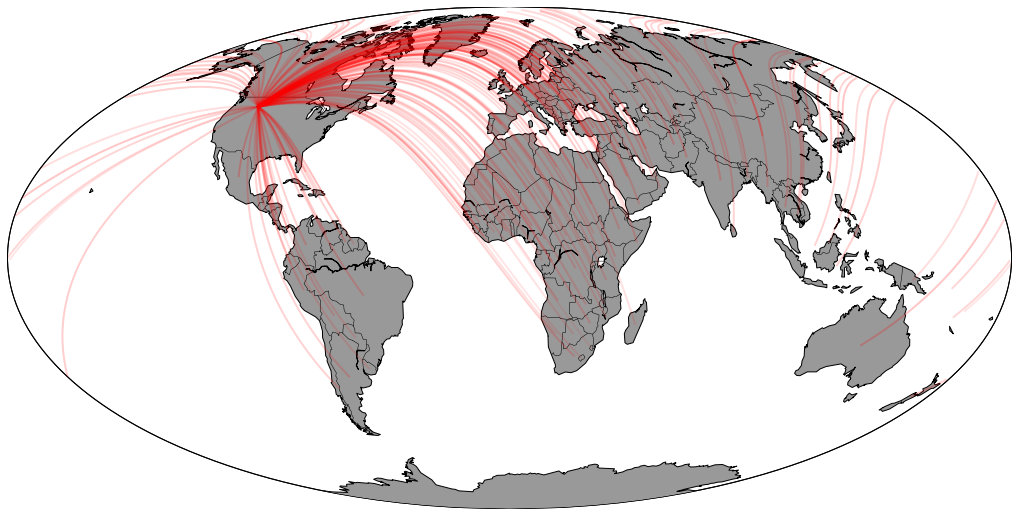

In [ ]:
plt.figure(figsize=(18,18))

# Load the world shape map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Country centroids, centroids here is not calculated by 2d projection
world['centroid'] = world.centroid
centroids = world.set_index('iso_a3')['centroid']

event_map =  Basemap(projection='moll',
                     llcrnrlat=-80,urcrnrlat=80,
                     llcrnrlon=-180,urcrnrlon=180, 
                     lon_0 = 0, lat_0 = 0)

event_map.drawcoastlines()
event_map.drawcountries()
event_map.fillcontinents(color='0.6')
event_map.drawmapboundary()


for index, row in grouped_df.iterrows():
    country1, country2 = row['sorted_pair']
    if country1 in centroids.index and country2 in centroids.index:
        point1 = centroids.loc[country1]
        point2 = centroids.loc[country2]
        
        line_alpha = get_alpha(row['count'])
        
        event_map.drawgreatcircle(point1.x, point1.y, point2.x, point2.y, 
                                  linewidth=2,
                                  color='r',
                                  alpha=line_alpha)
plt.show()